# Pytorch-super resolution Demo

In [7]:
# Load the package you are going to use
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
import platform
import os
from models.SRCNN.model import SRCNN
from models.FSRCNN.model import FSRCNN
from models.VDSR.model import VDSR
from models.ESPCN.model import ESPCN
from models.DRRN.model import DRRN
from models.ESPCN.model import ESPCN
from models.DRCN.model import DRCN
from models.LapSRN.model import LapSRN
from models.RDN.model import RDN
import cv2
from tqdm import tqdm
from PIL.PngImagePlugin import PngImageFile

%matplotlib inline
import h5py
import math
import copy

# import matlab.engine
# eng = matlab.engine.start_matlab()
# eng.addpath('./quant_eval')
# eng.addpath('./quant_eval/ifcvec_release')

In [8]:
# detect device
use_cuda = True
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [9]:
def get_platform_path():
    system = platform.system()
    data_dir, model_dir, checkpoint_dir, dirs = '', '', '', []
    if system == 'Windows':
        drive, common_dir = 'F', 'cache'
        data_dir = '{}:/{}/data'.format(drive, common_dir)
        model_dir = '{}:/{}/model'.format(drive, common_dir)
        checkpoint_dir = '{}:/{}/checkpoint'.format(drive, common_dir)
        dirs = [data_dir, model_dir, checkpoint_dir]

    elif system == 'Linux':
        common_dir = '/data'
        data_dir = '{}/data'.format(common_dir)
        model_dir = '{}/model'.format(common_dir)
        checkpoint_dir = '{}/checkpoint'.format(common_dir)
        dirs = [data_dir, model_dir, checkpoint_dir]

    for dir in dirs:
        if not os.path.exists(dir):
            os.mkdir(dir)

    return data_dir, model_dir, checkpoint_dir


In [10]:
# data/models/checkpoint in different platform
data_dir, model_dir, checkpoint_dir = get_platform_path()

In [11]:
data_dir

'F:/cache/data'

  - This model is trained on [291](https://drive.google.com/open?id=1Rt3asDLuMgLuJvPA1YrhyjWhb97Ly742) images with data augmentation
  - No bias is used in this implementation, and the gradient clipping's implementation is different from paper

In [12]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
# im_gt = Image.open("D:\jupyter\pytorch-vdsr\Set5/butterfly_GT.bmp").convert("RGB")
# im_b = Image.open("D:\jupyter\pytorch-vdsr\Set5/butterfly_GT_scale_3.bmp").convert("RGB")

file_gt = "{}\Set5_SR\image_SRF_2\img_001_SRF_2_HR.png".format(data_dir)
file_b = "{}\Set5_SR\image_SRF_2\img_001_SRF_2_LR.png".format(data_dir)

im_gt = Image.open(file_gt).convert("RGB")
im_b = Image.open(file_b).convert("RGB")

# file = h5py.File("D:\jupyter\SRCNN-pytorch\\Set5_x3.h5", 'r')
# im_gt_y = np.array(file['hr'][str(2)]).astype(float)
# im_b_y = np.array(file['lr'][str(2)]).astype(float)

# im_b = im_b.resize((250, 360), Image.BICUBIC)

In [13]:
# ITU-R BT.601
# https://en.wikipedia.org/wiki/YCbCr
# RGB -> YCbCr

# def rgb2ycbcr(rgb):
#     m = np.array([[ 65.481, 128.553, 24.966],
#                   [-37.797, -74.203, 112],
#                   [ 112, -93.786, -18.214]])
#     shape = rgb.shape
#     if len(shape) == 3:
#         rgb = rgb.reshape((shape[0] * shape[1], 3))
#     ycbcr = np.dot(rgb, m.transpose() / 255.)
#     ycbcr[:,0] += 16.
#     ycbcr[:,1:] += 128.
#     return ycbcr.reshape(shape)

# ITU-R BT.601
# https://en.wikipedia.org/wiki/YCbCr
# YUV -> RGB
# def ycbcr2rgb(ycbcr):
#     m = np.array([[ 65.481, 128.553, 24.966],
#                   [-37.797, -74.203, 112],
#                   [ 112, -93.786, -18.214]])
#     shape = ycbcr.shape
#     if len(shape) == 3:
#         ycbcr = ycbcr.reshape((shape[0] * shape[1], 3))
#     rgb = copy.deepcopy(ycbcr)
#     rgb[:,0] -= 16.
#     rgb[:,1:] -= 128.
#     rgb = np.dot(rgb, np.linalg.inv(m.transpose()) * 255.)
#     return rgb.clip(0, 255).reshape(shape)

In [14]:
# / 255
OrigT = np.array(
    [[ 65.481, 128.553, 24.966 ],
     [-37.797, -74.203, 112.0  ],
     [  112.0, -93.786, -18.214]])

OrigOffset = np.array([16, 128, 128])

# OrigT_inv = np.array([[0.00456621,  0.,  0.00625893],
#           [0.00456621, -0.00153632, -0.00318811],
#           [0.00456621,  0.00791071,  0.]])
OrigT_inv = np.linalg.inv(OrigT)


def rgb2ycbcr(rgb_img):
    if rgb_img.shape[2] == 1:
        return rgb_img
    if rgb_img.dtype == float:
        T = 1.0 / 255.0
        offset = 1 / 255.0
    elif rgb_img.dtype == np.uint8:
        T = 1.0 / 255.0
        offset = 1.0 
    elif rgb_img.dtype == np.uint16:
        T = 257.0 / 65535.0
        offset = 257.0
    else:
        raise Exception('the dtype of image does not support')
    T = T * OrigT
    offset = offset * OrigOffset
    ycbcr_img = np.zeros(rgb_img.shape, dtype=float)
    for p in range(rgb_img.shape[2]):
        ycbcr_img[:, :, p] = T[p, 0] * rgb_img[:, :, 0] + T[p, 1] * rgb_img[:, :, 1] + T[p, 2] * rgb_img[:, :, 2] + offset[p]
    return np.array(ycbcr_img, dtype=rgb_img.dtype)

def ycbcr2rgb(ycbcr_img):
    
    if ycbcr_img.shape[2] == 1:
        return ycbcr_img
    if ycbcr_img.dtype == float:
        T = 255.0
        offset = 1.0
    elif ycbcr_img.dtype == np.uint8:
        T = 255.0
        offset = 255.0
    elif ycbcr_img.dtype == np.uint16:
        T = 65535.0 / 257.0
        offset = 65535.0
    else:
        raise Exception('the dtype of image does not support')
    T = T * OrigT_inv
    offset = offset * np.matmul(OrigT_inv, OrigOffset)
    rgb_img = np.zeros(ycbcr_img.shape, dtype=float)
    for p in range(rgb_img.shape[2]):
        rgb_img[:, :, p] =  T[p, 0] * ycbcr_img[:, :, 0] + T[p, 1] * ycbcr_img[:, :, 1] + T[p, 2] * ycbcr_img[:, :, 2] - offset[p]
    return np.array(rgb_img.clip(0, 255), dtype=ycbcr_img.dtype)

In [15]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = rgb2ycbcr(np.array(im_gt))
im_b_ycbcr = rgb2ycbcr(np.array(im_b))
# im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
# im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

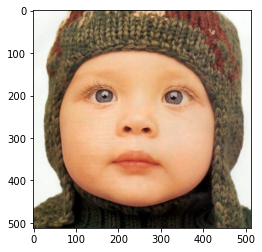

In [16]:
# test reverse function
im_b_rgb = ycbcr2rgb(im_gt_ycbcr)
plt.imshow(np.array(im_b_rgb, dtype=np.uint8))

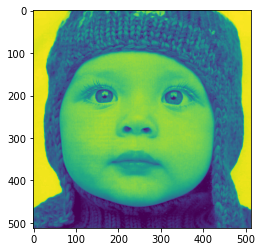

In [17]:
plt.imshow(im_gt_y)

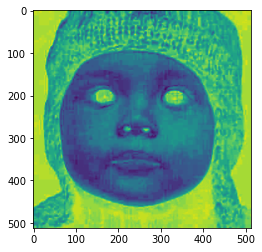

In [18]:
plt.imshow(im_gt_ycbcr[:,:,1].astype(float))

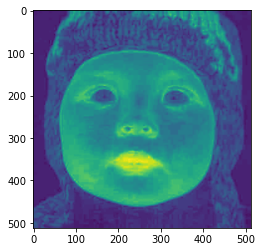

In [19]:
plt.imshow(im_gt_ycbcr[:,:,2].astype(float))

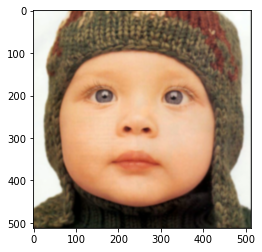

In [20]:
blurImg = cv2.GaussianBlur(im_b_rgb,(11,11),1.5, borderType=cv2.BORDER_ISOLATED)
plt.imshow(blurImg)

In [21]:
# Here is the funtion for shaving the edge of image
def shave(pred, gt, shave_border):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    return pred, gt

# Here is the function for PSNR calculation
def PSNR(pred, gt):
    imdff = pred - gt
    rmse = np.mean(imdff ** 2)
    if rmse == 0:
        return 100
    return 10 * math.log10(255 * 255 / rmse)

In [22]:
# Here is the function for SSIM calculation
def SSIM_index(pred, gt):
    height, width = pred.shape[:2]
    kernel_size = 11
    padding = kernel_size // 2
    std = 1.5
    if height < kernel_size or width < kernel_size:
        return float('-inf')
    K = [0.01, 0.03]
    L = 255
    C1, C2 = (K[0] * L) ** 2, (K[1] * L) ** 2
    pred, gt = np.array(pred, dtype=float), np.array(gt, dtype=float)
    mu1 = cv2.GaussianBlur(pred,(kernel_size, kernel_size), std, borderType=None)
    mu2 = cv2.GaussianBlur(gt,(kernel_size, kernel_size), std, borderType=None)
    mu1, mu2 = shave(mu1, mu2, padding)
    
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.GaussianBlur(pred * pred, (kernel_size, kernel_size), std, borderType=None)
    sigma2_sq = cv2.GaussianBlur(gt * gt, (kernel_size, kernel_size), std, borderType=None)
    sigma1_sq, sigma2_sq = shave(sigma1_sq, sigma2_sq, padding)
    sigma1_sq, sigma2_sq = sigma1_sq - mu1_sq, sigma2_sq - mu2_sq
    sigma12 = cv2.GaussianBlur(pred * gt, (kernel_size, kernel_size), std, borderType=None)
    sigma12, _ = shave(sigma12, sigma12, padding)
    sigma12 = sigma12 - mu1_mu2
    if C1 > 0 and C2 > 0:
        ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    else:
        pass
    mssim = np.mean(ssim_map)
    return mssim, ssim_map

In [23]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y: np.ndarray, ycbcr: np.ndarray) -> np.ndarray: 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = ycbcr2rgb(img)
    return img

def denormalize(img, color_range=255):
    img = img.mul((255.0 / color_range)).clamp(0.0, 255.0)
    return img

def getImage_y(img: PngImageFile) -> np.ndarray:
    if len(img.split()) == 3:
        im_b = np.array(img)
        im_ycbcr = rgb2ycbcr(im_b)
        im_y = im_ycbcr[:,:,0].astype(float)
    else:
        im_y = np.array(img).astype(float)
    return im_y

def mergeImage(im_b, out, color_range=1):
    out = out.cpu().data[0]
    im_h = np.array(denormalize(out, color_range), dtype=np.float32)
    im_h_y = im_h[0,:,:]
    
    im_b = np.array(im_b).astype(np.uint8)
    im_b_ycbcr = rgb2ycbcr(im_b).astype(np.float32)
    
    im_g_rgb = colorize(im_h_y, im_b_ycbcr)
    im_g_rgb[im_g_rgb < 0] = 0
    im_g_rgb[im_g_rgb > 255.] = 255.
    return im_g_rgb

def getImagePair_y(im_gt: PngImageFile, im_b: PngImageFile, use_bicubic: bool) -> [np.ndarray, np.ndarray]:
    if use_bicubic:
        im_b = im_b.resize(im_gt.size, Image.BICUBIC)
    im_gt_y, im_b_y = getImage_y(im_gt), getImage_y(im_b)
    return im_gt_y, im_b_y

def getModelInput(im_b:np.ndarray, color, color_range) -> torch.Tensor:
    if color == 'y':
        im_input = im_b / (255. / color_range)
        im_input = Variable(torch.from_numpy(im_input).float()).\
            view(1, -1, im_input.shape[0], im_input.shape[1]).to(device)
    elif color == 'rgb':
        im_input = im_b.astype(np.float32).transpose([2, 0, 1]) / (255.0 / color_range)
        im_input = Variable(torch.from_numpy(im_input).float()).\
            view(1, -1, im_input.shape[1], im_input.shape[2]).to(device)
    return im_input

def getModelOutput_y(out:torch.Tensor, color, color_range) -> np.ndarray:
    out = out.cpu().data[0]
    if color == 'y':
        im_h = np.array(denormalize(out, color_range), dtype=np.float32)
        im_h_y = im_h[0,:,:]
    elif color == 'rgb':
        im_h = np.transpose(np.array(denormalize(out, color_range), dtype=np.uint8), (1, 2, 0))
        im_h_ycbcr = rgb2ycbcr(im_h).astype(np.float32)
        im_h_y = im_h_ycbcr[:,:,0]
    return im_h_y

def getModelOutput_rgb(out:torch.Tensor, color, color_range) -> np.ndarray:
    out = out.cpu().data[0]
    im_h = np.array(denormalize(out, color_range), dtype=np.float32)
    return im_h

In [25]:
def avg_PSNR(num, dataset, use_bicubic = True, model = None, use_matlab=False,
             upscaleFactor = 3, save = False, color='y', output_name = "", color_range=255):
        
    total_psnr_y = 0
    total_ssim_y = 0
    total_psnr_rgb = 0
    total_ssim_rgb = 0
    for i in tqdm(range(1, 1 + num)):
        if i <= 9:
            index = '00' + str(i)
        elif i <= 99:
            index = '0' + str(i)
        else:
            index = str(i)
        file_b = "{}\{}\image_SRF_{}\img_{}_SRF_{}_LR.png".format(data_dir, dataset, upscaleFactor, index, upscaleFactor)
        file_gt = "{}\{}\image_SRF_{}\img_{}_SRF_{}_HR.png".format(data_dir, dataset, upscaleFactor, index, upscaleFactor)
        
        im_b, im_gt = Image.open(file_b).convert('RGB'), Image.open(file_gt).convert('RGB')
        im_b_np, im_gt_np = np.array(im_b), np.array(im_gt)
        
        im_gt_y, im_b_y = getImagePair_y(im_gt, im_b, use_bicubic)
        if model == None:
            im_b_y_shave, im_gt_y_shave = shave(im_b_y, im_gt_y, upscaleFactor)
            psnr = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            im_h_y = im_b_y
        else:
            # ========================== model start ==================================
            model = model.to(device)
            with torch.no_grad():
                
                if color.lower() == 'y':
                    im_input = getModelInput(im_b_y, color, color_range)
                elif color.lower() == 'rgb':
                    im_input = getModelInput(im_b_np, color, color_range)
                
                out = model(im_input)
                im_h = getModelOutput_rgb(out, color, color_range)
                im_h_y = getModelOutput_y(out, color, color_range)    
                
            # ========================== model end ==================================
            
            # evaluation on y channel
            im_b_y_shave, im_gt_y_shave = shave(im_h_y, im_gt_y, upscaleFactor)
            psnr_y = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim_y, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            
            # evaluation on rgb channel
            im_h_shave, im_gt_shave = shave(im_h.transpose(1,2,0), im_gt_np, upscaleFactor)
            psnr_rgb = PSNR(im_h_shave, im_gt_shave)
            ssim_rgb, _ = SSIM_index(im_h_shave, im_gt_shave)
            
        if save:
            if color == 'rgb':
                im_g_rgb = np.array(im_h, dtype=np.uint8)
            else:
                if not use_bicubic and len(im_b.shape) == 3:
                    im_g = im_b.resize(im_gt.size, Image.BICUBIC)
                    im_g_ycbcr = rgb2ycbcr(np.array(im_g))
                if len(im_b.shape) == 3:
                    im_g_rgb = colorize(im_h_y, im_g_ycbcr)
                else:
                    im_g_rgb = im_h_y
            
            im_g_rgb[im_g_rgb < 0] = 0
            im_g_rgb[im_g_rgb > 255.] = 255.
            
            # np.uint8
            img_save = Image.fromarray(im_g_rgb).convert("RGB")
            img_save.save(file_b.replace("LR", output_name))
            
        total_psnr_y += psnr_y
        total_ssim_y += ssim_y
        total_psnr_rgb += psnr_rgb
        total_ssim_rgb += ssim_rgb
    return total_psnr_y / num, total_ssim_y / num, total_psnr_rgb / num, total_ssim_rgb / num

In [ ]:
# Load the pretrained model
# model = VDSR(num_channels=1,num_residuals=20)
# model = SRCNN(num_channels=1, filter=64)
# model = FSRCNN(num_channels=1, upscale_factor=2)
# model = ESPCN(num_channels=1, upscale_factor=4)
# model = DRRN(num_channels=1)
# model = ESPCN(num_channels=1, upscale_factor=3)
# model = DRCN(num_channels=1, num_recursions=16)
model = RDN(r=3)
# model = LapSRN(num_channles=1)


checkpoint = torch.load('F:\\cache\\checkpoint\\RDN-(3,)x.pth', map_location='cuda:0')
# checkpoint = torch.load('F:\\cache\\model\\ESPCN-3x-91images.pth', map_location='cuda:0')

from collections import OrderedDict
new_state_dict = OrderedDict()
for key, value in checkpoint['net'].items():
    key = key.replace('module.', '')
    new_state_dict[key] = value
model.load_state_dict(new_state_dict)

In [26]:
upscaleFactor = 3
use_bicubic = False        # same size
output_name = "RDN"
save = False
color = 'rgb'
color_range = 1

In [27]:
avg_PSNR(5, 'Set5_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor,
         output_name=output_name, save=save, color=color, color_range=color_range)

100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


(34.392360691236306, 0.9263907906991872, 32.46469343406909, 0.9035255561428481)

In [28]:
avg_PSNR(14, 'Set14_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor,
         output_name=output_name, save=save, color=color, color_range=color_range)

100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


(30.35028887354401, 0.842314258467354, 28.507579433204832, 0.8112403421055104)

In [29]:
avg_PSNR(100, 'BSD100_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, 
         output_name=output_name, save=save, color=color, color_range=color_range)

100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


(29.097582645502555,
 0.8050247568613607,
 27.790263494252677,
 0.7883280066371541)

In [30]:
avg_PSNR(100, 'Urban100_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor,
         output_name=output_name, save=save, color=color, color_range=color_range)

100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


(28.517646024524215, 0.8663664945076883, 27.038207762599715, 0.855988644268983)

In [31]:
avg_PSNR(100, 'Manga109_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, 
         output_name=output_name, save=save, color=color, color_range=color_range)

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


(33.7802931193973, 0.9468635551269009, 31.892954987550866, 0.9291036154777192)

In [28]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpeg', '.jpg', '.bmp', '.JPEG'])

def avg_PSNR(LR_dir, HR_dir, data_range=800, use_bicubic = True, model = None, use_matlab=False,
             upscaleFactor = 3, save = False, color='y', output_name = "", color_range=255):
        
    total_psnr_y = 0
    total_ssim_y = 0
    total_psnr_rgb = 0
    total_ssim_rgb = 0
    
    if is_image_file(LR_dir):
        LR_filenames = [LR_dir]
        HR_filenames = [HR_dir]
    else:
        LR_filenames = os.listdir(LR_dir)
        HR_filenames = os.listdir(HR_dir)
        
    assert len(LR_filenames) == len(HR_filenames), \
            'The number of LR images is not equal to the number of the HR images.'
    
    LR_filenames.sort(key=lambda x: x[:-4])
    HR_filenames.sort(key=lambda x: x[:-4])
    
    LR_filenames = LR_filenames[config.data_range:]
    HR_filenames = HR_filenames[config.data_range:]
    
    for i in tqdm(range(len(LR_filenames))):
        
        file_b = "{}\{}".format(LR_dir, LR_filenames[i])
        file_gt = "{}\{}".format(HR_dir, HR_filenames[i])
        
        im_b, im_gt = Image.open(file_b).convert('RGB'), Image.open(file_gt).convert('RGB')
        im_b_np, im_gt_np = np.array(im_b), np.array(im_gt)
        
        im_gt_y, im_b_y = getImagePair_y(im_gt, im_b, use_bicubic)
        if model == None:
            im_b_y_shave, im_gt_y_shave = shave(im_b_y, im_gt_y, upscaleFactor)
            psnr = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            im_h_y = im_b_y
        else:
            # ========================== model start ==================================
            model = model.to(device)
            with torch.no_grad():
                
                if color.lower() == 'y':
                    im_input = getModelInput(im_b_y, color, color_range)
                elif color.lower() == 'rgb':
                    im_input = getModelInput(im_b_np, color, color_range)
                
                out = model(im_input)
                im_h = getModelOutput_rgb(out, color, color_range)
                im_h_y = getModelOutput_y(out, color, color_range)    
                
            # ========================== model end ==================================
            
            # evaluation on y channel
            im_b_y_shave, im_gt_y_shave = shave(im_h_y, im_gt_y, upscaleFactor)
            psnr_y = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim_y, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            
            # evaluation on rgb channel
            im_h_shave, im_gt_shave = shave(im_h.transpose(1,2,0), im_gt_np, upscaleFactor)
            psnr_rgb = PSNR(im_h_shave, im_gt_shave)
            ssim_rgb, _ = SSIM_index(im_h_shave, im_gt_shave)
            
        if save:
            if color == 'rgb':
                im_g_rgb = np.array(im_h, dtype=np.uint8)
            else:
                if not use_bicubic and len(im_b.shape) == 3:
                    im_g = im_b.resize(im_gt.size, Image.BICUBIC)
                    im_g_ycbcr = rgb2ycbcr(np.array(im_g))
                if len(im_b.shape) == 3:
                    im_g_rgb = colorize(im_h_y, im_g_ycbcr)
                else:
                    im_g_rgb = im_h_y
            
            im_g_rgb[im_g_rgb < 0] = 0
            im_g_rgb[im_g_rgb > 255.] = 255.
            
            # np.uint8
            img_save = Image.fromarray(im_g_rgb).convert("RGB")
            img_save.save(file_b.replace("LR", output_name))
            
        total_psnr_y += psnr_y
        total_ssim_y += ssim_y
        total_psnr_rgb += psnr_rgb
        total_ssim_rgb += ssim_rgb
    return total_psnr_y / num, total_ssim_y / num, total_psnr_rgb / num, total_ssim_rgb / num

In [ ]:
upscaleFactor = 3
use_bicubic = False        # same size
output_name = "RDN"
save = False
color = 'rgb'
color_range = 1
data_range = 800
LR_dir = 'F:\DIV2K\DIV2K_train_LR_bicubic_X4'
HR_dir = 'F:\DIV2K\DIV2K_train_HR'

In [ ]:
avg_PSNR(LR_dir=LR_dir,
         HR_dir=LR_dir, 
         data_range=data_range, 
         use_bicubic=use_bicubic,
         model=model, 
         upscaleFactor=upscaleFactor,
         output_name=output_name, 
         save=save, 
         color=color,
         color_range=color_range)

In [ ]:
# super-resolution resolve single image with y channel
img = Image.open('img_blur.png')
img_y = getImage_y(img)
img_input = getModelInput(img_y, color, color_range)
out = model(img_input)
img_rgb = mergeImage(img, out, color_range=1)
plt.imshow(img_rgb)

In [ ]:
# Calculate the PNSR for bicubic interpolation
# For best PSNR score, you will have to use Matlab for color space transformation, 
# since it is different from Python's implementation
psnr_bicubic = PSNR(im_gt_y, im_b_y)
print('psnr for bicubic is {}dB'.format(psnr_bicubic))

In [ ]:
# Prepare for the input, a pytorch tensor
if color == 'rgb':
    im_input = np.array(im_b, dtype=np.float32) / 255.0
else:
    im_input = im_b_y / 255.
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [ ]:
# Let's try the network feedforward in cpu mode
model = model.cpu()

In [ ]:
# Let's see how long does it take for processing
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in cpu mode".format(elapsed_time))

In [ ]:
# Now let's try the network feedforward in gpu mode
model = model.cuda()
im_input = im_input.cuda()

In [ ]:
# Let's see how long does it take for processing in gpu mode
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in gpu mode".format(elapsed_time))

In [ ]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [ ]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = PSNR(im_gt_y, im_h_y)
print('psnr for SR is {}dB'.format(psnr_predicted))

In [ ]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

In [ ]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

In [ ]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_gt)
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(im_b)
ax.set_title("Input(bicubic) {}".format(psnr_bicubic))

ax = plt.subplot("133")
ax.imshow(im_h)
ax.set_title("Output(SR) {}".format(psnr_predicted))
plt.show()

In [ ]:
import numpy as np
import os
HR = 'D:\\jupyter\\RDN\\RDN_TestCode\\HR\\Set5\\x2'
SR = 'D:\\jupyter\\RDN\\RDN_TestCode\\SR\\BI\\RDNplus\\Set5\\x2'
upscaleFactor = 2

In [ ]:
def test_LR_and_SR(SR, HR, upscaleFactor):
    SRs = os.listdir(SR)
    HRs = os.listdir(HR)
    
    size = len(SRs)
    
    total_psnr = 0
    total_ssim = 0
    
    for SR_file in SRs:
        SR_path = os.path.join(SR, SR_file)
        HR_file = SR_file.replace('RDNplus', 'HR')
        HR_path = os.path.join(HR, HR_file)
        
        SR_img = np.array(Image.open(SR_path), dtype=float)
        HR_img = np.array(Image.open(HR_path), dtype=float)
        
        im_b_y = rgb2ycbcr(SR_img)[:,:,0].astype(float)
        im_gt_y = rgb2ycbcr(HR_img)[:,:,0].astype(float)
    
        im_b_y_shave, im_gt_y_shave = shave(im_b_y, im_gt_y, upscaleFactor)
        psnr = PSNR(im_b_y_shave, im_gt_y_shave)
        ssim, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
        
        total_psnr += psnr
        total_ssim += ssim
        
    avg_psnr = total_psnr / size
    avg_ssim = total_ssim / size
    
    return avg_psnr, avg_ssim

In [ ]:
test_LR_and_SR(SR, HR, 2)